<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/pytorch_openpose_wavelet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Hzzone/pytorch-openpose  

In [1]:
!git clone https://github.com/Hzzone/pytorch-openpose

Cloning into 'pytorch-openpose'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.


In [2]:
%cd pytorch-openpose/

/content/pytorch-openpose


In [3]:
!mkdir model
%cd model
!wget -O models.zip https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=1
!unzip -o models.zip
%cd ..

/content/pytorch-openpose/model
--2019-08-05 05:33:56--  https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa [following]
--2019-08-05 05:33:56--  https://www.dropbox.com/sh/dl/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4e7f16e14b8759f30bf7f4944d.dl.dropboxusercontent.com/zip_by_token_key?dl=1&key=AmDvb6qFh-mRlbKlThMHKI_msDIJslFRVY3xjj3Cv-BlLqCxDGfzPhGZ440iPHYDs0VEFCyGppQjqHGh7YjrMZYq_OMJciI9bF-T8Y34i2LtoaOlXndOtxqi1cdecBrdtVP7WjbgfQgkQiSQJMm2Sa-GNkvNVNB1CVVSFtWmfCBmt-nmoAuZPDetscOz4ClH_akdB1uVSG4207kZ3kHei4UaCtFOgcDeanTmqCOZX9ht9VfnRuPwuDtcmtvFQaanDhY [following]
-

## run demo.pyを実行する前の注意

GPUで実行するためには./python/hand.pyの下記のを修正


``` python
output = self.model(data).numpy()
```

         ↓

``` python
output = self.model(data).cpu().numpy()
```

修正前にdemo.pyをしてhandをimportしてしまったら


```　python
import sys
sys.modules.pop('hand') # Unimport module forcely
```

を実行してhandを解除すること





In [0]:
# スクリプトの修正
with open('./python/hand.py') as f:
  txt = f.read()
with open('./python/hand.py', 'w') as f:
  f.write(txt.replace('output = self.model(data).numpy()',
            'output = self.model(data).cpu().numpy()'))


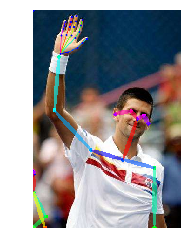

In [5]:
run demo.py

In [9]:
%cd images
!cp demo.jpg demo_org.jpg
%cd ..

/content/pytorch-openpose/images
/content/pytorch-openpose


LEVEL : 1
MOTHER_WAVELET db1
original image size:  (458, 310, 3)


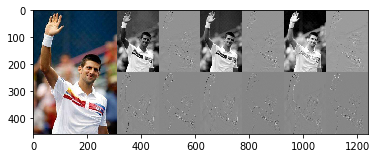

In [23]:
import pywt
import numpy as np
import cv2
from matplotlib import pyplot as plt

def image_normalization(src_img):
    """
    白飛び防止のための正規化処理
    cv2.imshowでwavelet変換された画像を表示するときに必要（大きい値を持つ画像の時だけ）
    """
    norm_img = (src_img - np.min(src_img)) / (np.max(src_img) - np.min(src_img))
    return norm_img

def merge_images(cA, cH_V_D):
    """numpy.array を４つ(左上、(右上、左下、右下))連結させる"""
    cH, cV, cD = cH_V_D
    cH = image_normalization(cH) # 外してもok
    cV = image_normalization(cV) # 外してもok
    cD = image_normalization(cD) # 外してもok
    cA = cA[0:cH.shape[0], 0:cV.shape[1]] # 元画像が2の累乗でない場合、端数ができることがあるので、サイズを合わせる。小さい方に合わせます。
    return np.vstack((np.hstack((cA,cH)), np.hstack((cV, cD)))) # 左上、右上、左下、右下、で画素をくっつける

def coeffs_visualization(cof):
    norm_cof0 = cof[0]
    norm_cof0 = image_normalization(norm_cof0) # 外してもok
    merge = norm_cof0
    for i in range(1, len(cof)):
        merge = merge_images(merge, cof[i])  # ４つの画像を合わせていく
    #merge_rgb = cv2.cvtColor(merge, cv2.COLOR_GRAY2RGB)
    max_value = np.max(merge)
    arr = np.uint8(merge* 255 / max_value) 
    plt.imshow(arr)
    cv2.imwrite('./images/demo.jpg', arr)
    
    return arr
    
    #cv2.imshow('', merge)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

def wavelet_transform_for_image(src_image, level, M_WAVELET="db1", mode="sym"):
    data = src_image.astype(np.float64)
    coeffs = pywt.wavedec2(data, M_WAVELET, level=level, mode=mode)
    return coeffs

if __name__ == "__main__":

    filename = './images/demo_org.jpg'
    LEVEL = 1

    # 'haar', 'db', 'sym' etc...
    # URL: http://pywavelets.readthedocs.io/en/latest/ref/wavelets.html
    MOTHER_WAVELET = "db1"

    im = cv2.imread(filename)

    print('LEVEL :', LEVEL)
    print('MOTHER_WAVELET', MOTHER_WAVELET)
    print('original image size: ', im.shape)

    """
    各BGRチャネル毎に変換
    cv2.imreadはB,G,Rの順番で画像を吐き出すので注意
    """
    B = 0
    G = 1
    R = 2
    coeffs_B = wavelet_transform_for_image(im[:, :, B], LEVEL, M_WAVELET=MOTHER_WAVELET)
    coeffs_G = wavelet_transform_for_image(im[:, :, G], LEVEL, M_WAVELET=MOTHER_WAVELET)
    coeffs_R = wavelet_transform_for_image(im[:, :, R], LEVEL, M_WAVELET=MOTHER_WAVELET)

    B = coeffs_visualization(coeffs_B)
    G = coeffs_visualization(coeffs_G)
    R = coeffs_visualization(coeffs_R)
    
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
    B = cv2.cvtColor(B, cv2.COLOR_GRAY2RGB)
    G = cv2.cvtColor(G, cv2.COLOR_GRAY2RGB)
    R = cv2.cvtColor(R, cv2.COLOR_GRAY2RGB)
    
    res = cv2.hconcat([im, B, G, R])
    
    res2 = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./images/demo.jpg', res2)
    
    plt.imshow(res)

In [0]:
# 結果を保存するようにスクリプトの修正
with open('./demo.py') as f:
  txt = f.read()
with open('./demo2.py', 'w') as f:
  f.write(txt.replace('canvas = util.draw_handpose(canvas, all_hand_peaks)',
            'canvas = util.draw_handpose(canvas, all_hand_peaks)\ncv2.imwrite(\'./images/result.jpg\',canvas)'))


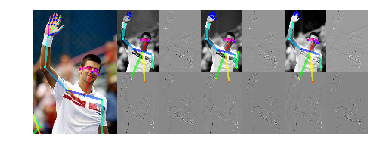

In [27]:
run demo2.py